In [1]:
from datetime import datetime, timezone
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import numpy as np
import mplfinance as mpf
import pandas as pd
from ta.volatility import BollingerBands

In [2]:
# No keys required for crypto data
client = CryptoHistoricalDataClient()
eastern = timezone(pd.Timedelta(hours=-4),'US/Eastern')

time_period = pd.Timedelta(hours=16)
time_period_end = datetime.now(tz=eastern)
time_period_start = datetime.now(tz=eastern)-time_period

# Creating request object
request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=TimeFrame.Minute,
  start=time_period_start-pd.Timedelta(hours=1), # offset request by an hour to avoid missing data
  end=time_period_end
)
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
btc_bars = client.get_crypto_bars(request_params)
# Convert to dataframe
df = btc_bars.df
# Update indexes to use only timestamp, as we are doing single symbol analysis
df = df.droplevel('symbol')
df.index = df.index.tz_convert('US/Eastern')

In [3]:
# Bollinger Bands
indicator_bb = BollingerBands(close=df.close, window=20, window_dev=2)
bollinger_bands = pd.DataFrame({
    'upper': indicator_bb.bollinger_hband(),
    'lower': indicator_bb.bollinger_lband()
})
def generate_high_marker_signal(series: pd.Series) -> list[float]:
    skip = False # skip repeated markers
    signal = []
    comparison = indicator_bb.bollinger_hband()
    for date,value in series.items():
        comparison_value = comparison.loc[date]
        if value > comparison_value and skip is False:
            signal.append(value * 1.002)
            skip = True
        else:
            signal.append(np.nan)
            if skip is True: skip = False
    return pd.Series(signal,index=series.index)
def generate_low_marker_signal(series: pd.Series) -> list[float]:
    skip = False # skip repeated markers
    signal = []
    comparison = indicator_bb.bollinger_lband()
    for date,value in series.items():
        comparison_value = comparison.loc[date]
        if value < comparison_value and skip is False:
            signal.append(value * 0.998)
            skip = True
        else:
            signal.append(np.nan)
            if skip is True: skip = False
    return pd.Series(signal,index=series.index)
# Subplot for BB
trim_signal = lambda sig: sig.truncate(before=time_period_start)
bb_subplot = mpf.make_addplot(trim_signal(bollinger_bands))
bb_marker_high_signal = generate_high_marker_signal(df.close)
bb_marker_low_signal = generate_low_marker_signal(df.close)
bb_high_marker_subplot = mpf.make_addplot(trim_signal(bb_marker_high_signal), type='scatter', markersize=20, marker="v", color='red', panel=0)
bb_low_marker_subplot = mpf.make_addplot(trim_signal(bb_marker_low_signal), type='scatter', markersize=20, marker="^", color='green', panel=0)

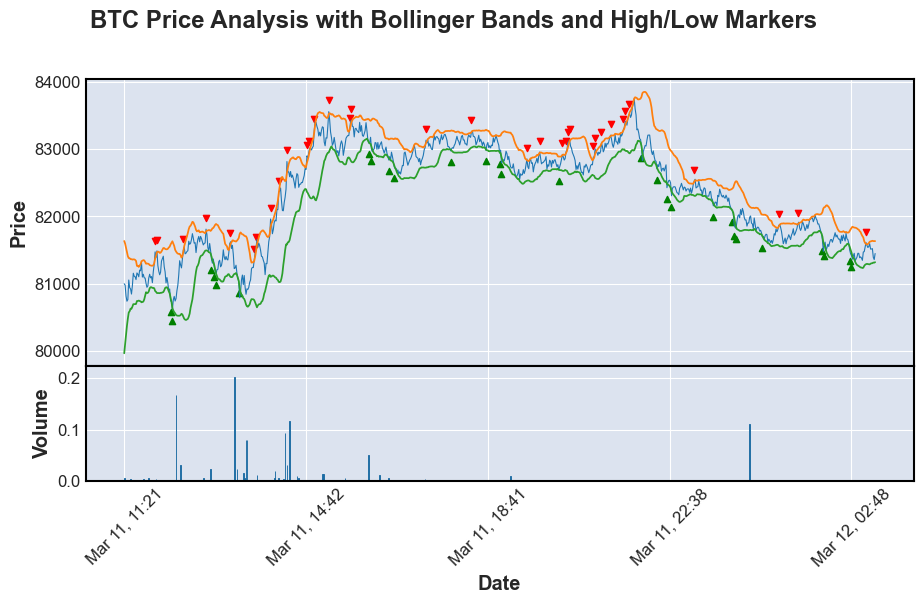

In [ ]:
# Plot everything
subplts = [bb_subplot, bb_high_marker_subplot, bb_low_marker_subplot]
trim_sig = df.truncate(before=time_period_start)
plt = mpf.plot(
    data=trim_sig, figratio=(10, 5),
    addplot=subplts,
    volume=True,
    type="line",
    xlabel="Date",
    ylabel="Price",
    title="BTC Price Analysis with Bollinger Bands and High/Low Markers",
)